# 📘 0. Introducción  
Este notebook evalúa la robustez de un modelo LeNet-5 entrenado sobre CIFAR-10, incluyendo versiones flotantes y cuantizadas. Además, se explora la sensibilidad del modelo ante fallos en los pesos mediante inyección de bit-flips.

**Contenidos:**
- Importación de librerías
- Carga y preprocesamiento del dataset CIFAR-10
- Definición de clases


In [ ]:
#1 Clasificación de imágenes con LeNet-5 preentrenado en CIFAR-10 (modo demo)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#2 Cargar y normalizar CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

#3 Nombres de clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# 🔧 1. Modelo Flotante (Keras clásico)




### 1.1 Definición y entrenamiento  
Construcción del modelo LeNet-5 adaptado a CIFAR-10 usando Keras, seguido de su entrenamiento y evaluación.

In [ ]:
#4 Simulación de LeNet-5 para CIFAR-10 (versión moderna adaptada a 32x32x3)
model = models.Sequential([
    layers.Conv2D(6, (5, 5), activation='relu', input_shape=(32, 32, 3), padding='same', name ='conv1'),
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, (5, 5), activation='relu', name ='conv2'),
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu', name ='fc1' ),
    layers.Dense(84, activation='relu', name ='fc2'),
    layers.Dense(10)  # 10 clases para CIFAR-10
])


#5 Compilar y entrenar (10 epochs)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# usar todo el x_train y x_test, no solo los primeros 10k y 2k, para mejorar el rendimiento general:
history = model.fit(x_train, y_train_cat, epochs=10,
                    validation_data=(x_test, y_test_cat))


#6 Evaluar
loss, acc = model.evaluate(x_test, y_test_cat, verbose=2)
print(f"\nEvaluación en test: Precisión = {acc:.2f}, Pérdida = {loss:.2f}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.3319 - loss: 1.8177 - val_accuracy: 0.4977 - val_loss: 1.3967
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.5097 - loss: 1.3633 - val_accuracy: 0.5459 - val_loss: 1.2695
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 53s 34ms/step - accuracy: 0.5565 - loss: 1.2393 - val_accuracy: 0.5499 - val_loss: 1.2432
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 51s 33ms/step - accuracy: 0.5993 - loss: 1.1220 - val_accuracy: 0.5954 - val_loss: 1.1390
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 33ms/step - accuracy: 0.6267 - loss: 1.0503 - val_accuracy: 0.5909 - val_loss: 1.1470
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.6494 - loss: 0.9908 - val_accuracy: 0.6162 - val_loss: 1.0920
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 35ms/step - accuracy: 0.6711 - loss: 0.9333 - val_accuracy: 0.6251 - val_loss: 1.0749
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.6919 -

## 1.2 Resultados  
Visualización del rendimiento del modelo entrenado usando matriz de confusión y prueba individual de predicción.


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


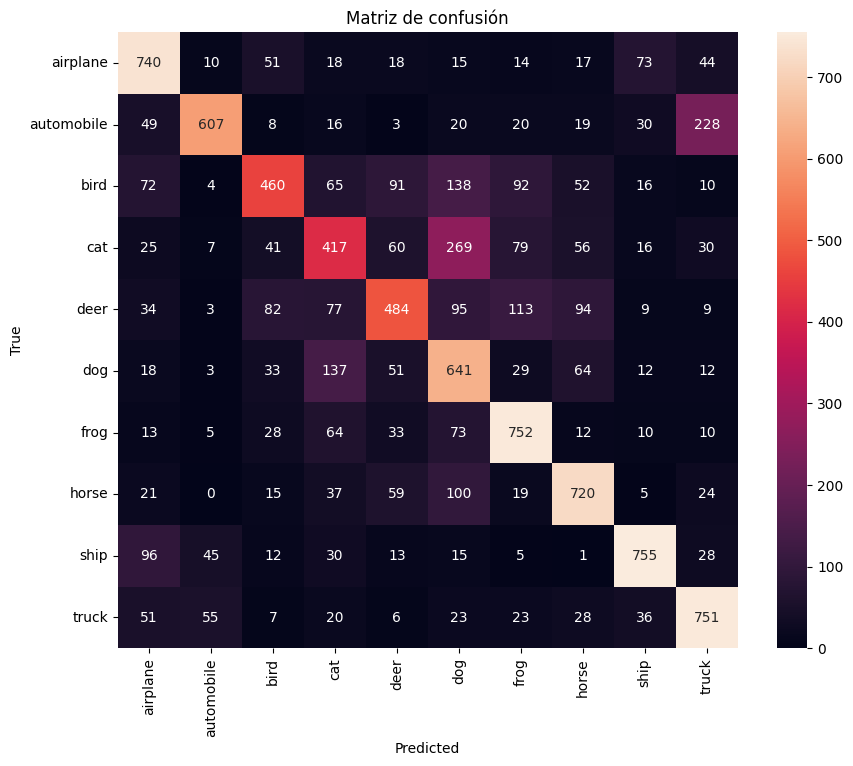

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


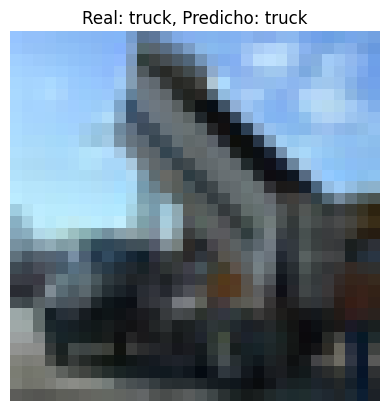

In [ ]:
#7 Matriz de confusión
pred_logits = model.predict(x_test)
preds = np.argmax(pred_logits, axis=1)
labels = y_test.flatten()

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de confusión')
plt.show()

#8 Clasificación de una imagen
index = 50
img = x_test[index]
pred = np.argmax(model.predict(np.expand_dims(img, axis=0)))

plt.imshow(img)
plt.title(f"Real: {class_names[labels[index]]}, Predicho: {class_names[pred]}")
plt.axis('off')
plt.show()

# ⚖️ 2. Guardar el modelo en sus diferentes formatos


2.1 Modelo original Keras .h5 (tras compilación en #5)

In [ ]:
model.save("my_model.keras")

print("Modelo keras (original) guardado como my_model.keras")

Modelo keras (original) guardado como my_model.keras


2.2 Modelo en su version FP32 TFLite

In [ ]:

model_keras = tf.keras.models.load_model("my_model.keras")

# creamos un convertidor desde el SaveModel

converter_fp32 = tf.lite.TFLiteConverter.from_keras_model(model_keras)

# luego convertimos y asignamos
tflite_model_fp32 = converter_fp32.convert()

with open("lenet_model_fp32.tflite", "wb") as f:
    f.write(tflite_model_fp32)

print("Modelo FP32 guardado en lenet_model_fp32.tflite")

Saved artifact at '/tmp/tmpdsttx_rm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137755376768720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376768528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376769680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376771408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376769296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376771984: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelo FP32 guarda

2.3 Modelo en su version Cuantizada Hibrida (Semi cuantizacion por defecto)

In [ ]:
# Conversor desde modelo Keras
converter_semi_quant = tf.lite.TFLiteConverter.from_keras_model(model_keras)

#Activar cuantización por defecto (cuantiza los pesos, pero no las activaciones)
converter_semi_quant.optimizations = [tf.lite.Optimize.DEFAULT]

# Convertir y guardar

semi_quant_model = converter_semi_quant.convert()

with open("lenet_model_semi_quant.tflite", "wb") as f:
    f.write(semi_quant_model)

print("✅ Modelo semi cuantizado guardado en lenet_model_semi_quant.tflite")


Saved artifact at '/tmp/tmptkrjqw8o'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137755376768720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376768528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376770448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376769680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376771408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376769296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755376771984: TensorSpec(shape=(), dtype=tf.resource, name=None)
✅ Modelo semi cuan

2.4 Modelo en su version cuantizadaTFLite INT 8

In [ ]:
def representative_dataset_gen():
    for i in range(100):
      image = x_train[i].astype(np.float32)
      image = tf.expand_dims(image, axis=0)
      yield [image]

model_keras = tf.keras.models.load_model("my_model.keras")

converter_int8 = tf.lite.TFLiteConverter.from_keras_model(model_keras)

converter_int8.optimizations = [tf.lite.Optimize.DEFAULT]
converter_int8.representative_dataset = representative_dataset_gen

# aumentamos el grado de control sobre la cuantización que necesitamos

converter_int8.target_spec.supported_types = [tf.int8]  # asegura que los pesos esten en int8
converter_int8.inference_input_type = tf.int8           # forzamos a que la entrada del modelo sea int 8 (no FP32)
converter_int8.inference_output_type = tf.int8          # forzamos a que la salida del modelo sea int 8

# convertir

tflite_model_int8 = converter_int8.convert()

# guardar
with open("lenet_model_int8.tflite", "wb") as f:
    f.write(tflite_model_int8)

print("Modelo INT 8 guardado en lenet_model_int8.tflite")

Saved artifact at '/tmp/tmpnuzixe4h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137755376767184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394624592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394622864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394624208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394624784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394624400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394625168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394624976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755394623824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137755276391056: TensorSpec(shape=(), dtype=tf.resource, name=None)
Modelo INT 8 guard

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# 🤖 3. Inferencia (Modelo en todas sus versiones)

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


🎯 Precisión modelo TFLite FP32:           0.6327
🎯 Precisión modelo TFLite CH (híbrido)        0.6328
🎯 Precisión modelo TFLite INT8 (cuant.):  0.6334

📦 Tamaño TFLite FP32:         328.12 KB
📦 Tamaño TFLite CH:      91.66 KB
📦 Tamaño TFLite INT8:         91.36 KB


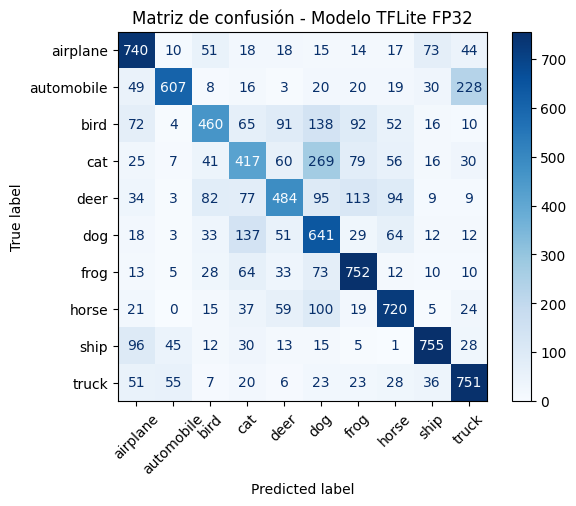

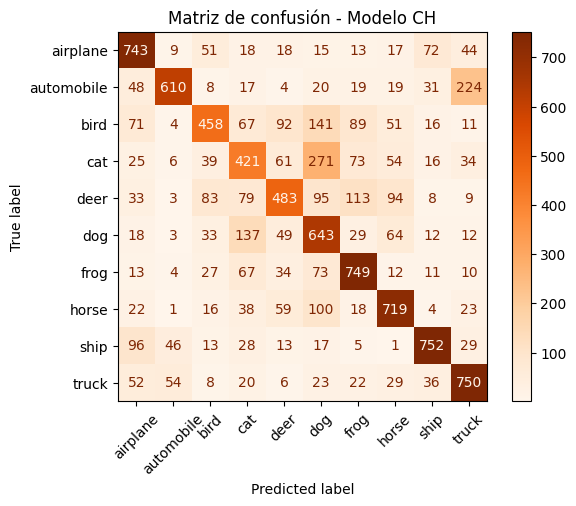

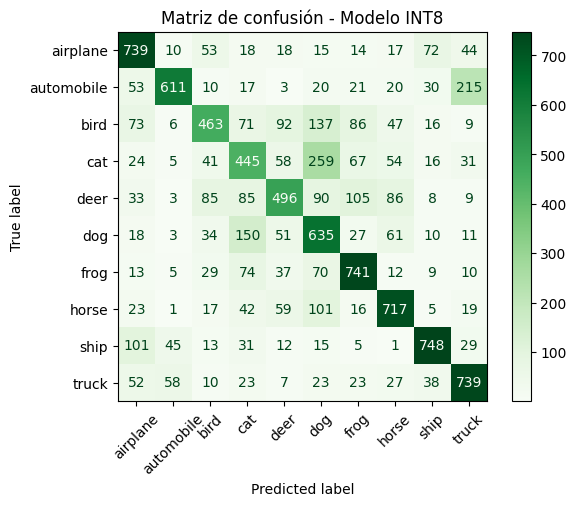

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

def run_tflite_inference(model_path, x_data, y_data):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    input_dtype = input_details[0]['dtype']
    input_scale, input_zero_point = input_details[0]['quantization']

    correct = 0
    y_preds = []

    for i in range(len(x_data)):
      img = x_data[i:i+1]

      if input_dtype == np.int8:
        img = img / input_scale + input_zero_point
        img = np.round(np.clip(img, -128, 127)).astype(np.int8)
      else :
        img = img.astype(np.float32)

      interpreter.set_tensor(input_index, img)
      interpreter.invoke()
      output = interpreter.get_tensor(output_index)
      pred = np.argmax(output)
      y_preds.append(pred)

      if pred == y_data[i]:
        correct += 1

    accuracy = correct / len(x_data)
    return accuracy, np.array(y_preds)

# Preparar datos
y_test_labels = np.argmax(y_test_cat, axis=1)

# Evaluar los tres modelos
acc_fp32, y_preds_fp32 = run_tflite_inference("lenet_model_fp32.tflite", x_test, y_test_labels)
acc_ch,   y_preds_ch   = run_tflite_inference("lenet_model_semi_quant.tflite", x_test, y_test)
acc_int8, y_preds_int8 = run_tflite_inference("lenet_model_int8.tflite", x_test, y_test_labels)


# Mostrar resultados
print(f"🎯 Precisión modelo TFLite FP32:           {acc_fp32:.4f}")
print(f"🎯 Precisión modelo TFLite CH (híbrido)        {acc_ch:.4f}")
print(f"🎯 Precisión modelo TFLite INT8 (cuant.):  {acc_int8:.4f}")



# Tamaño en KB
size_fp32 = os.path.getsize("lenet_model_fp32.tflite") / 1024
size_ch = os.path.getsize("lenet_model_semi_quant.tflite") / 1024
size_int8 = os.path.getsize("lenet_model_int8.tflite") / 1024


print(f"\n📦 Tamaño TFLite FP32:         {size_fp32:.2f} KB")
print(f"📦 Tamaño TFLite CH:      {size_ch:.2f} KB")
print(f"📦 Tamaño TFLite INT8:         {size_int8:.2f} KB")

# Matriz de confusión visual para modelo TFLite FP32
ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_preds_fp32, display_labels=class_names, cmap="Blues", xticks_rotation=45
).ax_.set_title("Matriz de confusión - Modelo TFLite FP32");

# Matriz de confusion para modelo cuantización híbrida

ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_preds_ch, display_labels=class_names, cmap="Oranges", xticks_rotation=45
).ax_.set_title("Matriz de confusión - Modelo CH");

# Matriz de confusión para modelo cuantizado
ConfusionMatrixDisplay.from_predictions(
    y_test_labels, y_preds_int8, display_labels=class_names, cmap="Greens", xticks_rotation=45
).ax_.set_title("Matriz de confusión - Modelo INT8");

# 🔍 4. Inspección de los pesos




Función 0: Calcula el tamaño de muestra necesario para una población finita de tamaño N, bajo un nivel de confianza y error específico.


In [ ]:
import math

def calcular_muestreo_estadistico(N=None, Z=1.96, p=0.5, e=0.05):
    """
    Calcula el tamaño de muestra necesario para una población INFINITA
    bajo un nivel de confianza y error específico.

    Parámetros:
    - Z: valor crítico para el nivel de confianza (default 1.96 para 95%)
    - p: proporción esperada de éxito (default 0.5)
    - e: margen de error permitido (default 0.05)

    Retorna:
    - int: tamaño de la muestra (n)
    """
    n = (Z**2) * p * (1 - p) / (e**2)
    return math.ceil(n)


Función 1 : Inspeccionar los tensores inyectables para el modelo FP32, CH e INT 8 (en una sola función)


In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

def inspeccionar_tensores_inyectables(model_path, tipo="fp32"):
    """
    Inspecciona los tensores inyectables de un modelo TFLite (.tflite) según su tipo.

    Parámetros:
    - model_path: Ruta del archivo .tflite
    - tipo: "fp32", "ch" o "int8"

    Retorna:
    - DataFrame con detalles de tensores inyectables y muestra estadística n
    """
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    tensor_details = interpreter.get_tensor_details()

    tensores_info = []
    for detail in tensor_details:
        idx = detail["index"]
        dtype = detail["dtype"]
        name = detail["name"]
        shape = detail["shape"]

        try:
            tensor = interpreter.get_tensor(idx)
        except Exception:
            continue

        if tensor.size == 0:
            continue

        # Validación de tipo
        es_fp32 = (tipo == "fp32" and dtype == np.float32)
        es_int8 = (tipo == "int8" and dtype == np.int8)
        es_ch   = (tipo == "ch" and dtype in [np.float32, np.int8])

        if es_fp32 or es_int8 or es_ch:
            if tipo == "int8":
                es_inyectable = ("pseudo_qconst" in name or "const" in name or "kernel" in name or "weights" in name)
            else:
                es_inyectable = ("const" in name or "kernel" in name or "weights" in name)

            if es_inyectable:
                bits_por_peso = 32 if dtype == np.float32 else 8
                total_bits = tensor.size * bits_por_peso
                n = calcular_muestreo_estadistico(total_bits)

                tensores_info.append({
                    "IndexModelo": idx,
                    "Nombre": name,
                    "TipoDato": str(dtype),
                    "Forma": shape,
                    "# Pesos": tensor.size,
                    "Bits por Peso": bits_por_peso,
                    "Total Bits Inyectables": total_bits,
                    "n (muestra estadística)": n
                })

    df = pd.DataFrame(tensores_info)
    df = df.sort_values(by="IndexModelo").reset_index(drop=True)
    return df


4.1 TFLite FP32 : Invocación

In [ ]:
# ✅ Invocar función f1 sobre el modelo
df_fp32 = inspeccionar_tensores_inyectables("lenet_model_fp32.tflite", tipo="fp32")

# ✅ Mostrar los tensores inyectables
print(f"✅ Tensores inyectables detectados: {len(df_fp32)}")
display(df_fp32)

✅ Tensores inyectables detectados: 8


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


,IndexModelo,Nombre,TipoDato,Forma,# Pesos,Bits por Peso,Total Bits Inyectables,n (muestra estadística)
0,1,arith.constant,<class 'numpy.float32'>,[16],16,32,512,385
1,2,arith.constant1,<class 'numpy.float32'>,"[16, 5, 5, 6]",2400,32,76800,385
2,3,arith.constant2,<class 'numpy.float32'>,"[10, 84]",840,32,26880,385
3,4,arith.constant3,<class 'numpy.float32'>,"[84, 120]",10080,32,322560,385
4,5,arith.constant4,<class 'numpy.float32'>,"[120, 576]",69120,32,2211840,385
5,6,arith.constant5,<class 'numpy.float32'>,[84],84,32,2688,385
6,7,arith.constant6,<class 'numpy.float32'>,[120],120,32,3840,385
7,8,arith.constant7,<class 'numpy.float32'>,[10],10,32,320,385


4.2 TFLite CH (Semi Cuantización) : Invocación

In [ ]:
# ✅ Invocar función f1 sobre el modelo
df_ch = inspeccionar_tensores_inyectables("lenet_model_semi_quant.tflite", tipo="ch")

# ✅ Mostrar los tensores inyectables
print(f"✅ Tensores inyectables detectados: {len(df_ch)}")
display(df_ch)

✅ Tensores inyectables detectados: 10


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


,IndexModelo,Nombre,TipoDato,Forma,# Pesos,Bits por Peso,Total Bits Inyectables,n (muestra estadística)
0,1,arith.constant,<class 'numpy.float32'>,[6],6,32,192,385
1,2,arith.constant1,<class 'numpy.float32'>,"[6, 5, 5, 3]",450,32,14400,385
2,4,arith.constant3,<class 'numpy.float32'>,[10],10,32,320,385
3,5,arith.constant4,<class 'numpy.float32'>,[120],120,32,3840,385
4,6,arith.constant5,<class 'numpy.float32'>,[84],84,32,2688,385
5,7,arith.constant6,<class 'numpy.float32'>,"[10, 84]",840,32,26880,385
6,8,arith.constant7,<class 'numpy.float32'>,[16],16,32,512,385
7,9,tfl.pseudo_qconst,<class 'numpy.int8'>,"[16, 5, 5, 6]",2400,8,19200,385
8,10,tfl.pseudo_qconst1,<class 'numpy.int8'>,"[84, 120]",10080,8,80640,385
9,11,tfl.pseudo_qconst2,<class 'numpy.int8'>,"[120, 576]",69120,8,552960,385


4.3 TFLite INT 8 : Invocación

In [ ]:
# ✅ Invocar función f1 sobre el modelo
df_int8 = inspeccionar_tensores_inyectables("lenet_model_int8.tflite", tipo="int8")

# ✅ Mostrar los tensores inyectables
print(f"✅ Tensores inyectables detectados: {len(df_int8)}")
display(df_int8)

✅ Tensores inyectables detectados: 5


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


,IndexModelo,Nombre,TipoDato,Forma,# Pesos,Bits por Peso,Total Bits Inyectables,n (muestra estadística)
0,3,tfl.pseudo_qconst1,<class 'numpy.int8'>,"[10, 84]",840,8,6720,385
1,5,tfl.pseudo_qconst3,<class 'numpy.int8'>,"[84, 120]",10080,8,80640,385
2,7,tfl.pseudo_qconst5,<class 'numpy.int8'>,"[120, 576]",69120,8,552960,385
3,9,tfl.pseudo_qconst7,<class 'numpy.int8'>,"[16, 5, 5, 6]",2400,8,19200,385
4,11,tfl.pseudo_qconst9,<class 'numpy.int8'>,"[6, 5, 5, 3]",450,8,3600,385


# 🔍 5. Evaluación del modelo sin inyecciones (baseline)

Antes de realizar cualquier campaña de inyección de fallos, es necesario obtener la línea base de funcionamiento del modelo LeNet-5 en condiciones normales. (Ya se realiazó con la primera inferencia)

Con ello solo recopilamos los datos obtenidos de la precision para luego guardarlos en un csv


In [ ]:
import pandas as pd

# Crear DataFrame
df = pd.DataFrame({
    "label": y_test_labels,
    "pred_fp32": y_preds_fp32,
    "pred_int8": y_preds_int8,
    "pred_ch" : y_preds_ch
})

# Guardar como baseline
df.to_csv("baseline_predictions_10k.csv", index=False)
print("✅ Archivo 'baseline_predictions_10k.csv' creado correctamente.")


✅ Archivo 'baseline_predictions_10k.csv' creado correctamente.


#💡 6. Inyección

 6.  🔬 Función: `realizar_inyeccion_sbf(...)`

Esta función permite realizar una campaña de inyecciones de fallos por bit-flip (Single Bit Flip - SBF) sobre modelos TFLite.

In [ ]:
def realizar_inyeccion_sbf(model_path, df_tensores, x_test, y_test_labels, acc_baseline, N=1):
    """
    Realiza una campaña de inyección SBF sobre todos los tensores inyectables del modelo TFLite.

    Parámetros:
    - model_path: ruta al archivo .tflite
    - df_tensores: DataFrame resultante de la inspección previa
    - x_test, y_test_labels: datos de prueba y etiquetas
    - acc_baseline: precisión sin fallos (float entre 0 y 1)
    - N: número de bit-flips aleatorios por tensor

    Retorna:
    - DataFrame con los resultados por tensor
    """
    import tensorflow as tf
    import numpy as np
    import pandas as pd
    import random

    resultados = []

    with open(model_path, "rb") as f:
        model_bytes_original = f.read()

    for _, row in df_tensores.iterrows():
        tensor_name = row["Nombre"]
        tensor_idx = row["IndexModelo"] # su posición en el modelo
        dtype_str = row["TipoDato"]

        print(f"\n🚧 Inyectando en: {tensor_name} (index={tensor_idx}, tipo={dtype_str})")

        # 1. Obtener contenido real del tensor
        interpreter_tmp = tf.lite.Interpreter(model_path=model_path)   # aqui se accede a los tensores interno del modelo .tflite que se paso usando model_path
        interpreter_tmp.allocate_tensors()                             # aqui se inicializa , reservando la memoria interna necesaria
        try:
            tensor_data = interpreter_tmp.get_tensor(tensor_idx)       # guarda los datos reales del tensor en tensor_data
        except Exception:
            print(f"❌ No se pudo acceder al tensor {tensor_name}. Saltando...")
            continue
        tensor_bytes = tensor_data.tobytes()                           # convierte los datos del tensor en bytes lista para el SBF ya que tensor_data es un array NumPy, no una secuencia de bytes cruda.

        # 2. Buscar patrón en modelo
        start_offset = model_bytes_original.find(tensor_bytes)         # esto es un cruce entre el modelo orginal y el tensor (ambos en bytes), para obtener la posicion incnial donde aparce. Crucial saber donde empiexa el tesnor en el archivo y que parte de os bytes camabiará.
        if start_offset == -1:
            print(f"❌ No se encontró el tensor '{tensor_name}' en el binario. Saltando...")
            continue

        # 3. Mutar modelo en la región del tensor
        model_bytes_mutado = bytearray(model_bytes_original)       # creamos una copia de porque los bytes originales son innmutables.
        pesos_modificados = set()                                  # guardamos las posiciones de los bytes modificados para ratrer el efecto o afectacion
        for _ in range(N):
            local_offset = random.randint(0, len(tensor_bytes) - 1)      # de forma aleatoria dentrreo del rango de bytes del tensor
            bit_index = random.randint(0, 7)                             # tambien bit aleatroio del 0 al 7
            model_bytes_mutado[start_offset + local_offset] ^= (1 << bit_index)   # inyeccion real sbf

            # Agrupar por tipo                        # Guarda qué posición lógica del peso fue modificada, según el tipo
            if "float32" in dtype_str:
                pesos_modificados.add(local_offset // 4)
            elif "int8" in dtype_str:
                pesos_modificados.add(local_offset)

        # 4. Ejecutar inferencia sobre el modelo mutado
        interpreter = tf.lite.Interpreter(model_content=bytes(model_bytes_mutado))
        interpreter.allocate_tensors()

        input_index = interpreter.get_input_details()[0]['index']
        output_index = interpreter.get_output_details()[0]['index']
        input_details = interpreter.get_input_details()[0]
        input_dtype = input_details['dtype']

        if input_dtype == np.int8:
            input_scale, input_zero_point = input_details['quantization']

        correct = 0
        for i in range(len(x_test)):
            img = x_test[i:i+1]

            if input_dtype == np.int8:
                img_q = img / input_scale + input_zero_point
                img_q = np.round(np.clip(img_q, -128, 127)).astype(np.int8)
            else:
                img_q = img.astype(np.float32)

            interpreter.set_tensor(input_index, img_q)
            interpreter.invoke()                           # La inferencia respeta el formato del modelo original para no introducir errores ajenos al fallo
            output = interpreter.get_tensor(output_index)
            pred = np.argmax(output)

            if pred == y_test_labels[i]:
                correct += 1

        acc_post = correct / len(x_test)
        delta = acc_post - acc_baseline

        resultados.append({
            "Index Modelo": tensor_idx,
            "Tensor": tensor_name,
            "TipoDato": dtype_str,
            "Forma": tuple(tensor_data.shape),
            "# Pesos": len(tensor_data.flatten()),
            "Total Bits Inyectables": len(tensor_bytes) * 8,
            "Pesos Modificados": len(pesos_modificados),
            "Acc Baseline": round(acc_baseline * 100, 2),
            "Acc Post-inyección": round(acc_post * 100, 2),
            "Degradación (%)": round(delta * 100, 2)
        })

    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values(by="Degradación (%)")
    return df_resultados


In [ ]:
# Ejemplo de Uso para FP32

df_resultados_fp32 = realizar_inyeccion_sbf(
    model_path="lenet_model_fp32.tflite",
    df_tensores=df_fp32,
    x_test=x_test,
    y_test_labels=y_test_labels,
    acc_baseline=acc_fp32,
    N=385
)

display(df_resultados_fp32)

# Guardar resultados en csv
df_resultados_fp32.to_csv("df_resultados_fp32.csv", index=False)
print("✅ Archivo 'df_resultados_fp32.csv' creado correctamente.")




🚧 Inyectando en: arith.constant (index=1, tipo=<class 'numpy.float32'>)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



🚧 Inyectando en: arith.constant1 (index=2, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant2 (index=3, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant3 (index=4, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant4 (index=5, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant5 (index=6, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant6 (index=7, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant7 (index=8, tipo=<class 'numpy.float32'>)


,Index Modelo,Tensor,TipoDato,Forma,# Pesos,Total Bits Inyectables,Pesos Modificados,Acc Baseline,Acc Post-inyección,Degradación (%)
4,5,arith.constant4,<class 'numpy.float32'>,"(120, 576)",69120,2211840,383,63.27,9.31,-53.96
0,1,arith.constant,<class 'numpy.float32'>,"(16,)",16,512,16,63.27,10.00,-53.27
5,6,arith.constant5,<class 'numpy.float32'>,"(84,)",84,2688,84,63.27,10.00,-53.27
6,7,arith.constant6,<class 'numpy.float32'>,"(120,)",120,3840,118,63.27,10.00,-53.27
7,8,arith.constant7,<class 'numpy.float32'>,"(10,)",10,320,10,63.27,10.00,-53.27
1,2,arith.constant1,<class 'numpy.float32'>,"(16, 5, 5, 6)",2400,76800,367,63.27,10.36,-52.91
2,3,arith.constant2,<class 'numpy.float32'>,"(10, 84)",840,26880,308,63.27,13.79,-49.48
3,4,arith.constant3,<class 'numpy.float32'>,"(84, 120)",10080,322560,376,63.27,29.57,-33.70


✅ Archivo 'df_resultados_fp32.csv' creado correctamente.


In [ ]:
# Ejemplo de Uso para CH

df_resultados_ch = realizar_inyeccion_sbf(
    model_path="lenet_model_semi_quant.tflite",
    df_tensores=df_ch,
    x_test=x_test,
    y_test_labels=y_test_labels,
    acc_baseline=acc_ch,
    N=385
)

display(df_resultados_ch)

# Guardar resultados en csv
df_resultados_ch.to_csv("df_resultados_ch.csv", index=False)
print("✅ Archivo 'df_resultados_ch.csv' creado correctamente.")



🚧 Inyectando en: arith.constant (index=1, tipo=<class 'numpy.float32'>)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



🚧 Inyectando en: arith.constant1 (index=2, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant3 (index=4, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant4 (index=5, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant5 (index=6, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant6 (index=7, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: arith.constant7 (index=8, tipo=<class 'numpy.float32'>)

🚧 Inyectando en: tfl.pseudo_qconst (index=9, tipo=<class 'numpy.int8'>)

🚧 Inyectando en: tfl.pseudo_qconst1 (index=10, tipo=<class 'numpy.int8'>)

🚧 Inyectando en: tfl.pseudo_qconst2 (index=11, tipo=<class 'numpy.int8'>)


,Index Modelo,Tensor,TipoDato,Forma,# Pesos,Total Bits Inyectables,Pesos Modificados,Acc Baseline,Acc Post-inyección,Degradación (%)
0,1,arith.constant,<class 'numpy.float32'>,"(6,)",6,192,6,63.28,10.00,-53.28
1,2,arith.constant1,<class 'numpy.float32'>,"(6, 5, 5, 3)",450,14400,262,63.28,10.00,-53.28
2,4,arith.constant3,<class 'numpy.float32'>,"(10,)",10,320,10,63.28,10.00,-53.28
3,5,arith.constant4,<class 'numpy.float32'>,"(120,)",120,3840,112,63.28,10.00,-53.28
4,6,arith.constant5,<class 'numpy.float32'>,"(84,)",84,2688,83,63.28,10.00,-53.28
6,8,arith.constant7,<class 'numpy.float32'>,"(16,)",16,512,16,63.28,10.00,-53.28
5,7,arith.constant6,<class 'numpy.float32'>,"(10, 84)",840,26880,312,63.28,16.45,-46.83
7,9,tfl.pseudo_qconst,<class 'numpy.int8'>,"(16, 5, 5, 6)",2400,19200,349,63.28,32.99,-30.29
9,11,tfl.pseudo_qconst2,<class 'numpy.int8'>,"(120, 576)",69120,552960,384,63.28,62.90,-0.38
8,10,tfl.pseudo_qconst1,<class 'numpy.int8'>,"(84, 120)",10080,80640,381,63.28,62.97,-0.31


✅ Archivo 'df_resultados_ch.csv' creado correctamente.


In [ ]:
# Ejemplo de Uso para INT 8

df_resultados_int8 = realizar_inyeccion_sbf(
    model_path="lenet_model_int8.tflite",
    df_tensores=df_int8,
    x_test=x_test,
    y_test_labels=y_test_labels,
    acc_baseline=acc_int8,
    N=385
)

display(df_resultados_int8)

# Guardar los resultados en csv
df_resultados_int8.to_csv("df_resultados_int8.csv", index=False)
print("✅ Archivo 'df_resultados_int8.csv' creado correctamente.")



🚧 Inyectando en: tfl.pseudo_qconst1 (index=3, tipo=<class 'numpy.int8'>)


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)



🚧 Inyectando en: tfl.pseudo_qconst3 (index=5, tipo=<class 'numpy.int8'>)

🚧 Inyectando en: tfl.pseudo_qconst5 (index=7, tipo=<class 'numpy.int8'>)

🚧 Inyectando en: tfl.pseudo_qconst7 (index=9, tipo=<class 'numpy.int8'>)

🚧 Inyectando en: tfl.pseudo_qconst9 (index=11, tipo=<class 'numpy.int8'>)


,Index Modelo,Tensor,TipoDato,Forma,# Pesos,Total Bits Inyectables,Pesos Modificados,Acc Baseline,Acc Post-inyección,Degradación (%)
4,11,tfl.pseudo_qconst9,<class 'numpy.int8'>,"(6, 5, 5, 3)",450,3600,257,63.34,29.60,-33.74
3,9,tfl.pseudo_qconst7,<class 'numpy.int8'>,"(16, 5, 5, 6)",2400,19200,354,63.34,47.83,-15.51
0,3,tfl.pseudo_qconst1,<class 'numpy.int8'>,"(10, 84)",840,6720,309,63.34,55.23,-8.11
1,5,tfl.pseudo_qconst3,<class 'numpy.int8'>,"(84, 120)",10080,80640,379,63.34,62.33,-1.01
2,7,tfl.pseudo_qconst5,<class 'numpy.int8'>,"(120, 576)",69120,552960,383,63.34,63.21,-0.13


✅ Archivo 'df_resultados_int8.csv' creado correctamente.
